In [1]:
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
sys.path.append("../")

import utils_ML as uml

In [2]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

all_data = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/quantile_norm_NSAF.csv", index_col = "assay_id")
all_data = all_data[all_data.index.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)
all_data.sort_index(inplace=True)

data=data.reset_index(drop=True)
meta=meta.reset_index(drop=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [3]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [4]:
# Impute
feature_names = data.columns
dataset = data.reset_index(drop=True).rename(columns={feature_names[x]:x for x in range(len(data.columns))})
imputer = uml.LowestValueImputerGaussian()
dataset = imputer.fit_transform(dataset,targets)
dataset = dataset.rename(columns={x:feature_names[x] for x in range(len(feature_names))})

# Pairwise corrlations predictive of functional association?

In [5]:
corr_matrix = dataset.corr()

In [6]:
corr_trian = corr_matrix.where(np.triu(np.ones(corr_matrix.shape)).astype(np.bool)).reset_index().melt(id_vars='index').dropna()

In [7]:
corr_trian = corr_trian[corr_trian["index"] != corr_trian["variable"]]

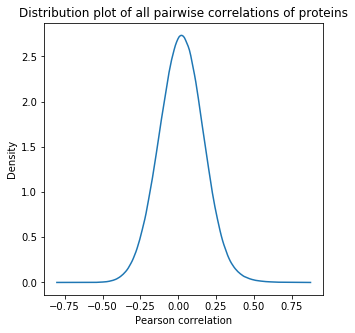

In [127]:
plt.figure(figsize=(5, 5))
plt.title("Distribution plot of all pairwise correlations of proteins")
plt.xlabel("Pearson correlation")
sns.kdeplot(corr_trian["value"])

Validate these with StringDB

In [8]:
# downloaded at https://string-db.org/cgi/download.pl (version 11.5)
string_interactions = pd.read_csv("string_interaction_scores_all.csv").reset_index(drop=True)

In [9]:
corr_trian = corr_trian.rename(columns={"index":"protein1", "variable": "protein2"})
matched_string_correlations = corr_trian.merge(string_interactions, how="left",left_on=["protein1", "protein2"], right_on=["protein1", "protein2"]).fillna(0)

In [176]:
# From all pairwise interactions
# 3,404,187 were not biologically related with high confidence
# 13,618 are biologically related with high confidence
print((matched_string_correlations["combined_score"]<900).value_counts())
print((matched_string_correlations["combined_score"]<700).value_counts())
print((matched_string_correlations["combined_score"]<400).value_counts())

True     3404187
False      13618
Name: combined_score, dtype: int64
True     3391388
False      26417
Name: combined_score, dtype: int64
True     3350700
False      67105
Name: combined_score, dtype: int64


In [168]:
len(matched_string_correlations)

3417805

In [10]:
matched_string_correlations["value"].max()

0.8511447174207908

In [11]:
matched_string_correlations["abs_value"] = abs(matched_string_correlations["value"])

In [18]:
(matched_string_correlations[matched_string_correlations["abs_value"]> .5]["combined_score"]>900).value_counts()

False    6328
True      856
Name: combined_score, dtype: int64

In [19]:
(matched_string_correlations[matched_string_correlations["abs_value"]> .5]["combined_score"]>700).value_counts()

False    5900
True     1284
Name: combined_score, dtype: int64

In [22]:
(matched_string_correlations[matched_string_correlations["abs_value"]> .5]["combined_score"]>400).value_counts()

False    5295
True     1889
Name: combined_score, dtype: int64

In [15]:
309/(1240+309)

0.19948353776630084

In [13]:
pearson_cutoff = []
ratio_confirmed_interactions = {"900": [], "700": [], "400": []}
scores = ["900","700","400"]

for x in np.arange(.8, 0, -0.01):
    ratio90 =(matched_string_correlations[matched_string_correlations["abs_value"]>x]["combined_score"]>900).value_counts()
    ratio70 =(matched_string_correlations[matched_string_correlations["abs_value"]>x]["combined_score"]>700).value_counts()
    ratio40 = (matched_string_correlations[matched_string_correlations["abs_value"]>x]["combined_score"]>400).value_counts()
    ratios = [ratio90, ratio70, ratio40]

    pearson_cutoff.append(x)
    for i,ratio in enumerate(ratios):
        ratio_confirmed_interactions[scores[i]].append(ratio[1]/(ratio[0]+ratio[1]))


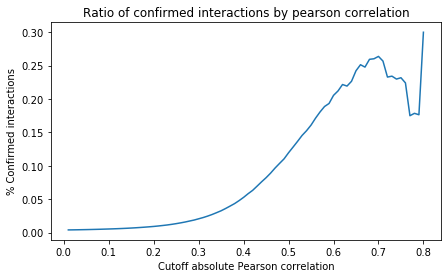

In [165]:
plt.figure(figsize=(7,4))
plt.title("Ratio of confirmed interactions by pearson correlation")
plt.xlabel("Cutoff absolute Pearson correlation")
plt.ylabel("% Confirmed interactions")
sns.lineplot(x=pearson_cutoff, y=ratio_confirmed_interactions)

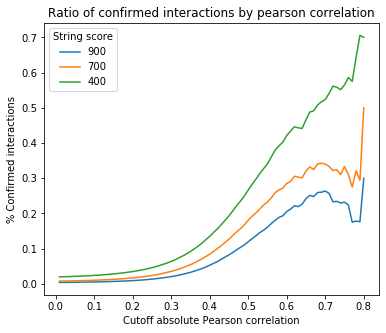

In [187]:
df = pd.concat([pd.DataFrame(ratio_confirmed_interactions),pd.Series(pearson_cutoff, name="Pearson")],axis=1)
df = df.melt(id_vars="Pearson")
df = df.rename(columns={"variable": "String score"})

plt.figure(figsize=(6,5))
plt.title("Ratio of confirmed interactions by pearson correlation")
plt.xlabel("Cutoff absolute Pearson correlation")
plt.ylabel("% Confirmed interactions")
sns.lineplot(data=df, x="Pearson", y="value", hue="String score")

In [183]:
df.melt(id_vars="Pearson")

,Pearson,variable,value
0,0.80,900,0.300000
1,0.79,900,0.176471
2,0.78,900,0.178571
3,0.77,900,0.175000
4,0.76,900,0.224138
...,...,...,...
235,0.05,400,0.021305
236,0.04,400,0.020865
237,0.03,400,0.020493
238,0.02,400,0.020128


In [ ]:
matched_string_correlations[matched_string_correlations[matched_string_correlations["abs_value"]>.7]["combined_score"]>900]

In [14]:
highest_correlators = matched_string_correlations[matched_string_correlations["abs_value"]>.7]

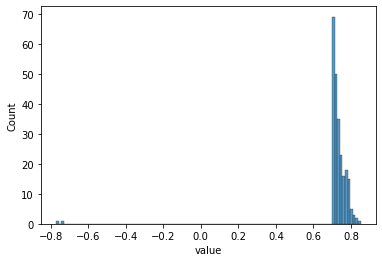

In [20]:
sns.histplot(highest_correlators["value"])

In [15]:
proteins = highest_correlators.protein1.tolist() + highest_correlators.protein2.tolist()

In [16]:
len(set(proteins))

100

In [17]:
p_count = {}
for p in set(proteins):
    p_count[p] = proteins.count(p)

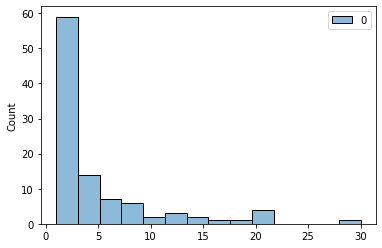

In [18]:
sns.histplot(p_count.values())

In [19]:
for i,x in p_count.items():
    if x>=25:
        print(i)

Q9NR30


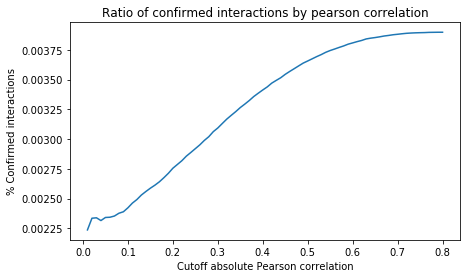

In [167]:
plt.figure(figsize=(7,4))
plt.title("Ratio of confirmed interactions by pearson correlation")
plt.xlabel("Cutoff absolute Pearson correlation")
plt.ylabel("% Confirmed interactions")
sns.lineplot(x=pearson_cutoff, y=ratio_confirmed_interactions)

In [24]:
len(set(proteins))

100

In [70]:
lut={x:sns.color_palette("tab20")[:8][x-1] for x in cluster_labels}


In [71]:
pd.Series(cluster_labels).map(lut)

0     (0.12156862745098039, 0.4666666666666667, 0.70...
1     (0.12156862745098039, 0.4666666666666667, 0.70...
2          (1.0, 0.596078431372549, 0.5882352941176471)
3     (0.12156862745098039, 0.4666666666666667, 0.70...
4     (0.12156862745098039, 0.4666666666666667, 0.70...
                            ...                        
95    (0.12156862745098039, 0.4666666666666667, 0.70...
96    (0.12156862745098039, 0.4666666666666667, 0.70...
97    (0.596078431372549, 0.8745098039215686, 0.5411...
98    (0.12156862745098039, 0.4666666666666667, 0.70...
99    (0.12156862745098039, 0.4666666666666667, 0.70...
Length: 100, dtype: object

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


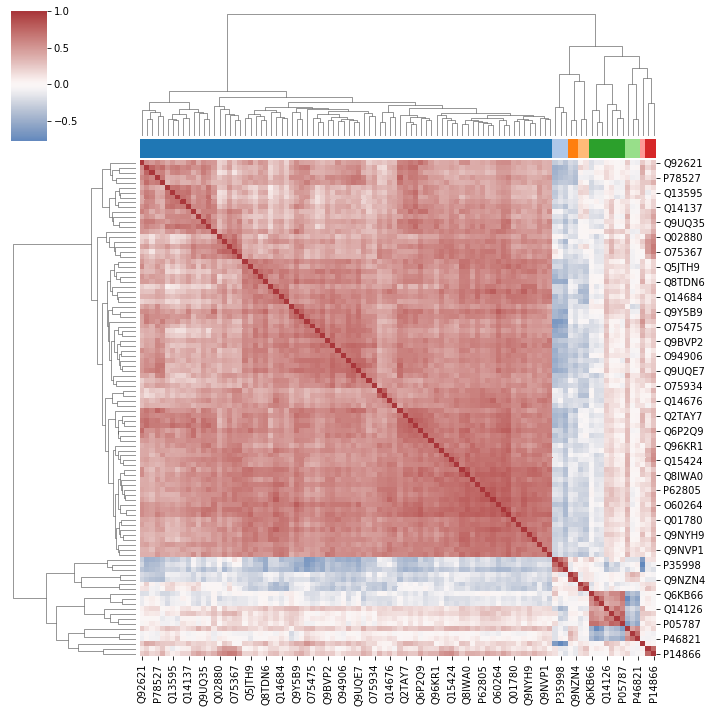

In [72]:
a = sns.clustermap(corr_matrix.loc[set(proteins), set(proteins)], cmap="vlag", center=0, col_colors=pd.Series(cluster_labels).map(lut).values)

In [34]:
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import squareform

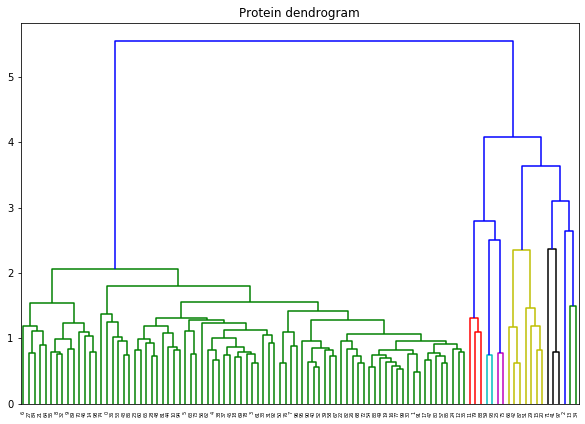

In [68]:
plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

clusters = shc.linkage(corr_matrix.loc[set(proteins), set(proteins)], metric="euclidean",
            method='average')

shc.dendrogram(Z=clusters, color_threshold=2.5)
cluster_labels = shc.fcluster(clusters, t=2.5, criterion="distance")
plt.show()

In [73]:
# Desmosome and keratin filaments + S100A4
for x in np.array(list(set(proteins)))[cluster_labels==5]:
    print(x)

P15924
P05787
P05783
Q9Y446
Q14126
Q6KB66
Q9HCY8


cluster 2
- 26S proteasome regulatory subunit 7
- alpha actinin 4
- gamma-glutamyl hydrolase

negatively correlated with: U2 small nuclear RNA auxiliary factor 1

In [77]:
for x in range(1,9):
    print("cluster",x)
    for p in np.array(list(set(proteins)))[cluster_labels==x]:
        print(p)

cluster 1
Q02880
Q9Y2X3
P12270
P49792
P42166
Q92621
Q14676
Q13595
Q9HCD5
Q14684
Q9NVP1
Q9UQ35
P62805
Q01780
P42285
Q14692
P78527
Q96KR1
Q15397
Q9Y5J1
Q15061
P23246
Q9Y3T9
O60264
P49790
P31942
Q15459
Q8IY81
O00567
Q9BVP2
Q9H307
Q6P2Q9
Q15393
O75367
P46013
Q99459
Q5BKZ1
Q9BZE4
Q8TDN6
Q15050
P10412
Q08211
P20700
Q9UNX4
P62995
Q13151
Q9NYH9
Q15029
Q5JTH9
Q9UQE7
O75475
Q9Y5B9
Q07666
Q03701
Q96DI7
Q15424
O94906
O75643
Q14151
Q03252
Q08945
P16403
Q8WYP5
Q12874
Q9UIG0
Q9Y3A2
P46087
Q8IWA0
Q96PK6
Q9BVJ6
P18583
Q14137
Q2TAY7
Q9NR30
O75934
Q13823
O75533
Q8WWQ0
P08621
P11388
cluster 2
O43707
P35998
Q92820
cluster 3
Q6NZI2
Q9NZN4
cluster 4
P06576
Q14697
cluster 5
P15924
P05787
P05783
Q9Y446
Q14126
Q6KB66
Q9HCY8
cluster 6
Q02952
P08670
P46821
cluster 7
Q00839
P14866
cluster 8
Q01081


In [76]:
# anticorrelated with cluster 5: Vimentin, A-kinase anchor protein 12 and MAP1B
for x in np.array(list(set(proteins)))[cluster_labels==6]:
    print(x)

Q02952
P08670
P46821


In [175]:
matched_string_correlations.sort_values("value")[-10:]

,protein1,protein2,value,combined_score,high_confidence_interaction,cumsum,abs_value
3306474,O60264,Q9Y5B9,0.803732,784.0,False,13615,0.803732
3165429,Q8IWA0,Q9Y2X3,0.805110,998.0,True,13616,0.805110
3164317,P11388,Q9Y2X3,0.808685,162.0,False,13616,0.808685
266532,P11388,P46013,0.808872,988.0,True,13617,0.808872
2922600,P11388,Q9UIG0,0.809780,264.0,False,13617,0.809780
435225,P11388,P62805,0.819847,650.0,False,13617,0.819847
1502958,P11388,Q8WYP5,0.822072,0.0,False,13617,0.822072
2496942,P11388,Q9NR30,0.826585,455.0,False,13617,0.826585
3060660,Q8IWA0,Q9UNX4,0.836256,993.0,True,13618,0.836256
3166105,Q9NR30,Q9Y2X3,0.852257,820.0,False,13618,0.852257


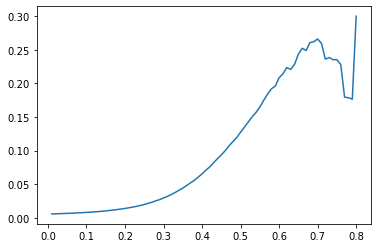

In [153]:
sns.lineplot(x=pearson_cutoff, y=ratio_confirmed_interactions)

In [131]:
(matched_string_correlations["combined_score"]>900).value_counts()

False    3404482
True       13323
Name: combined_score, dtype: int64

In [117]:
matched_string_correlations["high_confidence_interaction"] = matched_string_correlations.combined_score.apply(lambda x: True if x>=900 else False)
matched_string_correlations["cumsum"] = matched_string_correlations.sort_values("value").high_confidence_interaction.transform("cumsum")
cumulative_corr_interaction = matched_string_correlations.sort_values("value")[matched_string_correlations.sort_values("value")["cumsum"].diff() != 0]
cumulative_corr_interaction["abs_value"] = abs(cumulative_corr_interaction["value"])

In [120]:
cumulative_corr_interaction["abs_cumsum"] = cumulative_corr_interaction.sort_values("abs_value").high_confidence_interaction.transform("cumsum")

In [122]:
cumulative_corr_interaction.sort_values("abs_value")

,protein1,protein2,value,combined_score,high_confidence_interaction,cumsum,abs_value,abs_cumsum
1989916,P61960,Q9BTM9,-0.000042,908.0,True,3034,0.000042,1
2207622,Q8IXM3,Q9H0U6,-0.000071,989.0,True,3033,0.000071,2
1221242,P20340,Q8IWJ2,-0.000072,998.0,True,3032,0.000072,3
2755504,O43181,Q9P0J0,-0.000122,999.0,True,3031,0.000122,4
810256,P31150,Q15907,0.000128,959.0,True,3035,0.000128,5
...,...,...,...,...,...,...,...,...
1215655,Q14692,Q8IWA0,0.783931,997.0,True,13614,0.783931,13614
2498560,Q9BZE4,Q9NR30,0.787283,962.0,True,13615,0.787283,13615
3165429,Q8IWA0,Q9Y2X3,0.805110,998.0,True,13616,0.805110,13616
266532,P11388,P46013,0.808872,988.0,True,13617,0.808872,13617


Text(0, 0.5, 'Cumulative sum of high confidence interactions')

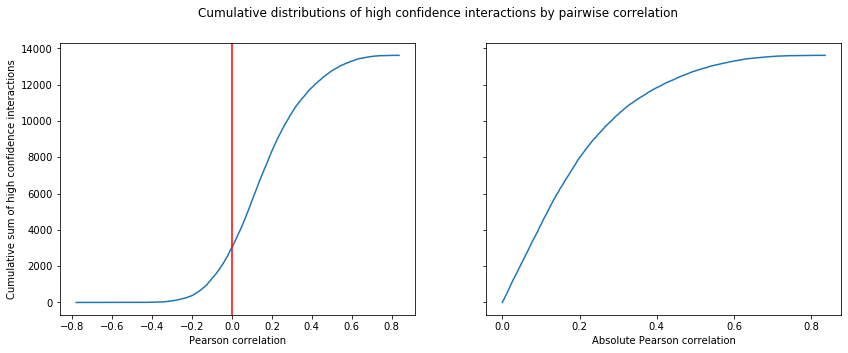

In [129]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)

sns.lineplot(data=cumulative_corr_interaction, x="value", y="cumsum", ax=ax[0])
sns.lineplot(data=cumulative_corr_interaction.sort_values("abs_value"), x="abs_value", y="abs_cumsum", ax=ax[1])

fig.suptitle("Cumulative distributions of high confidence interactions by pairwise correlation")
ax[0].axvline(0, c="r")
ax[0].set_xlabel("Pearson correlation")
ax[1].set_xlabel("Absolute Pearson correlation")
ax[0].set_ylabel("Cumulative sum of high confidence interactions")

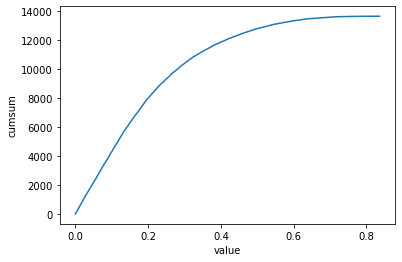

In [91]:
sns.lineplot(data=cumulative_corr_interaction, x="value", y="cumsum")

---

In [23]:
# String API to check biological significance of clusters
import requests
import time
df = []
string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv-no-header"
method = "network"
## Construct URL
request_url = "/".join([string_api_url, output_format, method])

f = IntProgress(min=0, max= 7141) # splits * preprocessors * oversampling methods * models
display(f)

for i,x in potential_interactors_5.iterrows():
    f.value += 1
    my_proteins = [x["index"], x["variable"]]

    params = {
        "identifiers" : "%0d".join(my_proteins), # Proteins
        "species" : 9606, # species NCBI identifier 
        "caller_identity" : "www.awesome_app.org", # app name
        }

    response = requests.post(request_url, data=params)
    df_output = []
    # Parse output
    for line in response.text.strip().split("\n"):
        l = line.strip().split("\t")
        if l==[""]:
            interaction = False
            break
        else:
            print(l)
            interaction = True
            df_output.append(l[5:])
            break

    if interaction:
        output = pd.DataFrame(df_output, index=[i], columns="score nscore fscore pscore ascore escore dscore tscore".split())
        output = output.astype({x:'float' for x in 'score nscore fscore pscore ascore escore dscore tscore'.split()})
        df.append(output)

IntProgress(value=0, max=7141)

['9606.ENSP00000244230', '9606.ENSP00000370589', 'MPHOSPH10', 'NOP56', '9606', '0.999', '0', '0', '0', '0.832', '0.974', '0.72', '0.529']
['9606.ENSP00000310448', '9606.ENSP00000363313', 'SART1', 'PRPF4', '9606', '0.999', '0', '0', '0', '0.184', '0.995', '0.9', '0.727']
['9606.ENSP00000315379', '9606.ENSP00000363313', 'PRPF3', 'PRPF4', '9606', '0.999', '0', '0', '0', '0.23', '0.998', '0.9', '0.988']
['9606.ENSP00000310448', '9606.ENSP00000315379', 'SART1', 'PRPF3', '9606', '0.999', '0', '0', '0', '0.216', '0.998', '0.9', '0.799']
['9606.ENSP00000232888', '9606.ENSP00000281701', 'RRP9', 'NVL', '9606', '0.839', '0', '0', '0', '0.825', '0', '0', '0.119']
['9606.ENSP00000283131', '9606.ENSP00000483667', 'SMARCA5', 'CHD1', '9606', '0.738', '0', '0', '0', '0.331', '0.531', '0', '0.846']
['9606.ENSP00000283131', '9606.ENSP00000465099', 'SMARCA5', 'CD3EAP', '9606', '0.635', '0', '0', '0', '0.117', '0', '0.6', '0.052']
['9606.ENSP00000283131', '9606.ENSP00000297338', 'SMARCA5', 'RAD21', '9606',

In [25]:
string_interactions = pd.concat(df)
string_interactions.to_csv("string_interaction_scores.csv")

In [30]:
potential_interactors_5=potential_interactors_5.reset_index().rename(columns={"index":"protein1", "variable":"protein2", "level_0": "index"})

In [34]:
corr_string = potential_interactors_5.merge(string_interactions.reset_index(), how='left').fillna(0)

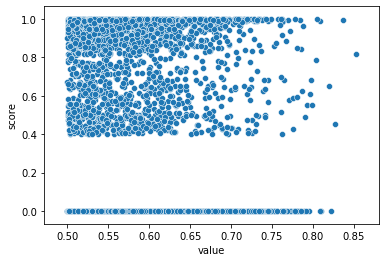

In [36]:
sns.scatterplot(data=corr_string, x='value', y='score')

In [40]:
scipy.stats.spearmanr(corr_string["value"], corr_string["score"])

SpearmanrResult(correlation=0.19967568914084619, pvalue=3.979152891546821e-65)

In [39]:
(corr_string[corr_string["value"]<=0.75].score == 0).value_counts()

True     5205
False    1867
Name: score, dtype: int64

In [47]:
corr_string[corr_string["value"]<0.75].mean()

index     4.551783e+06
value     5.608665e-01
score     2.104037e-01
nscore    3.874434e-04
fscore    7.253959e-05
pscore    1.415441e-03
ascore    1.410212e-01
escore    9.562981e-02
dscore    5.339649e-02
tscore    8.855062e-02
dtype: float64

In [48]:
corr_string[corr_string["value"]>0.75].mean()

index     4.816263e+06
value     7.789528e-01
score     4.453188e-01
nscore    1.347826e-03
fscore    0.000000e+00
pscore    0.000000e+00
ascore    2.772029e-01
escore    2.377246e-01
dscore    1.188406e-01
tscore    2.518841e-01
dtype: float64

In [ ]:
for x in set(corr_string[corr_string["value"] > 0.75].protein1.tolist() + corr_string[corr_string["value"] > 0.75].protein2.tolist()):
    print(x)

---

# Interpreting important features through correlation analysis

# Case 1: Colorectal cancer cell lines

correlation of the most important features

In [62]:
corr_CRC = dataset.loc[meta.Group=="CRC"].corr()

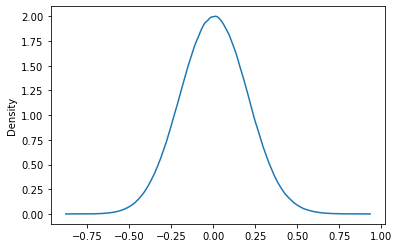

In [73]:
sns.kdeplot(list(corr_CRC.melt()[corr_CRC.melt().value != 1]["value"]))

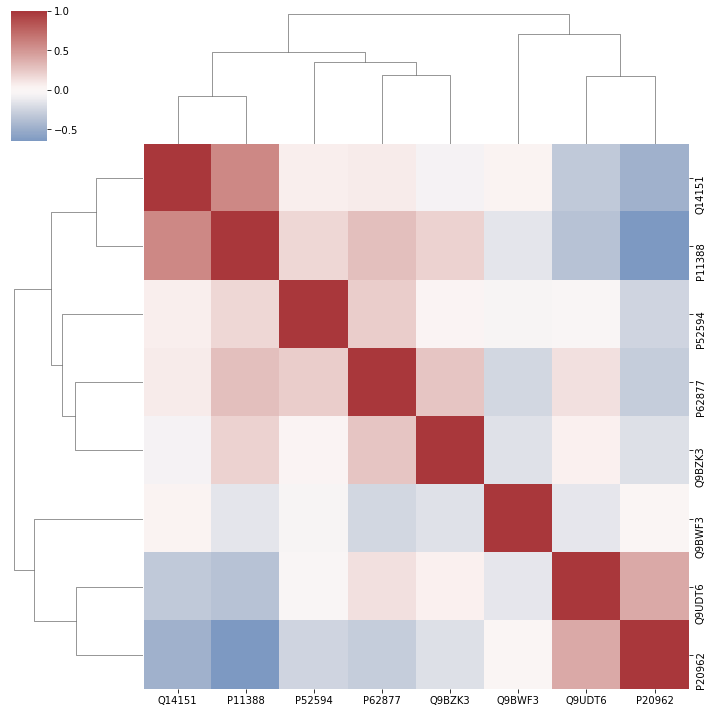

In [51]:
sns.clustermap(dataset.loc[meta.Group=="CRC", """P62877
Q9UDT6
Q9BWF3
Q14151
P11388
P52594
Q9BZK3
P20962""".split("\n")
].corr(), cmap="vlag", center=0)

Most important feature for classification was low expression of E3 ubiquitin-protein ligase RBX1 (P62877)

Is in complex with SKP1, CUL1 ("P63208", "Q13616"). Degrades cyclin E1 (P24864)

In [32]:
all_data = all_data.reset_index(drop=True)

The other complex components and the substrate were not found in the dataset

In [35]:
all_data.loc[meta.Group=="CRC",["P63208", "Q13616"]].isna().sum() / len(meta[meta.Group == "CRC"])

P63208    0.961538
Q13616    0.961538
dtype: float64

In [40]:
all_data.loc[meta.Group=="CRC", "P24864"].isna().sum() / len(meta[meta.Group == "CRC"])

0.9871794871794872

In [23]:
def get_correlation_matrix(data, proteins, group, threshold):
    corred_dict = {}
    subdata = data.loc[meta.Group.isin(group), :]
    for protein in proteins:
        protein_corr = subdata.corr(method="pearson")[protein]
        protein_corr = protein_corr.loc[~protein_corr.index.isin([protein])]
        
        corred = protein_corr[(protein_corr > threshold) | (protein_corr<-threshold)].index
        corred = protein_corr[(protein_corr > threshold) | (protein_corr<-threshold)].index

        if len(corred) > 0:
            g=sns.clustermap(subdata.loc[:, list(corred)+[protein]].corr(), cmap="vlag", center=0)
            g.fig.suptitle(protein)

            corred_dict[protein] = corred

        else:
            print(protein, "no correlations above", threshold,"found")
    return corred_dict

In [9]:
uniprot_description.loc[['P16152', 'P16403', 'P48651', 'P62304', 'Q6IAA8', 'Q96S52', 'Q99714',
        'Q9NWT1', 'Q9Y2V2', 'Q9Y3A2', 'Q9Y4Y9']]

,description
uniprot_id,
P16152,Carbonyl reductase [NADPH] 1
P16403,Histone H1.2
P48651,Phosphatidylserine synthase 1
P62304,Small nuclear ribonucleoprotein E
Q6IAA8,Ragulator complex protein LAMTOR1
Q96S52,GPI transamidase component PIG-S
Q99714,3-hydroxyacyl-CoA dehydrogenase type-2
Q9NWT1,p21-activated protein kinase-interacting prote...
Q9Y2V2,Calcium-regulated heat-stable protein 1


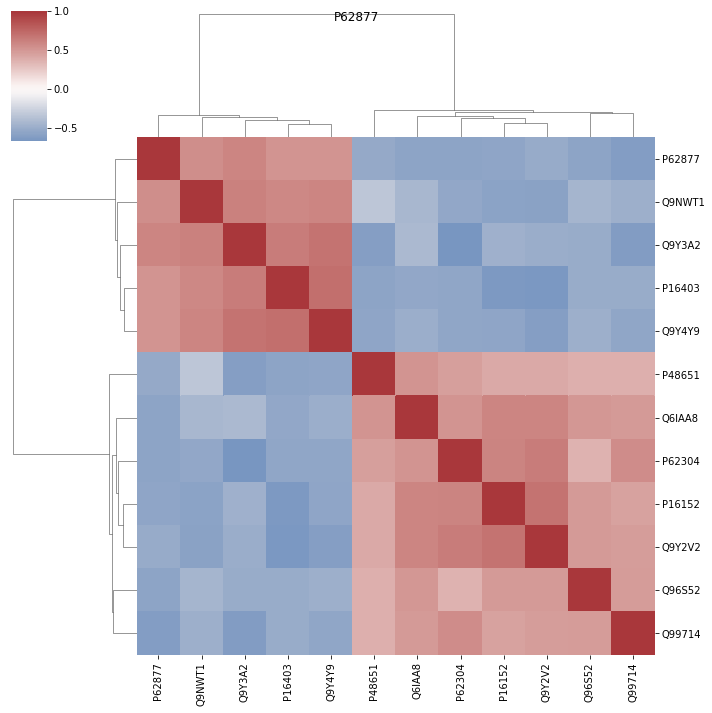

In [41]:
corr_rbx1 = get_correlation_matrix(dataset, ["P62877"], ["CRC"], .5)

In [61]:
def make_regplot(group, p1, p2):
    print("Correlation between {} and {}".format(uniprot_description.loc[p1].description, uniprot_description.loc[p2].description))
    p = pearsonr(dataset.loc[meta.Group.isin(group), p1], dataset.loc[meta.Group.isin(group), p2])
    print("Pearson correlation: {:.2f} (p-val: {})".format(p[0], p[1]))
    sns.regplot(dataset.loc[meta.Group.isin(group), p1], dataset.loc[meta.Group.isin(group), p2])

Correlation between E3 ubiquitin-protein ligase RBX1  and U6 snRNA-associated Sm-like protein LSm5
Pearson correlation: 0.58 (p-val: 2.435893876951671e-08)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


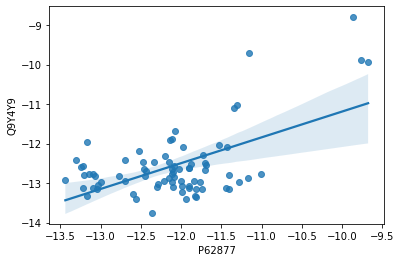

In [47]:
make_regplot(["CRC"], "P62877", "Q9Y4Y9")

Correlation between E3 ubiquitin-protein ligase RBX1  and Small nuclear ribonucleoprotein E 
Pearson correlation: -0.54 (p-val: 3.551709265828594e-07)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


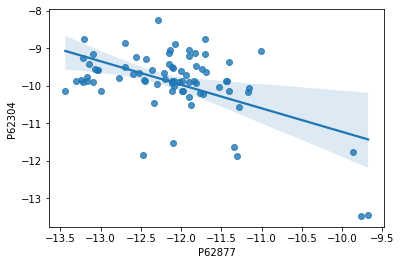

In [48]:
make_regplot(["CRC"], "P62877", "P62304")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


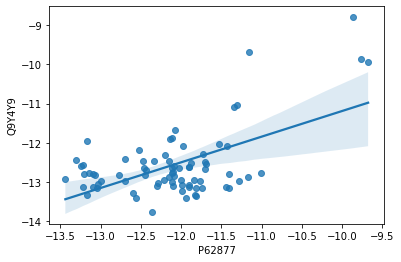

In [40]:
sns.regplot(dataset.loc[meta.Group == "CRC", "P62877"], dataset.loc[meta.Group == "CRC", "Q9Y4Y9"])

In [61]:
print("Missing values CRC-P62877: {:.2f}".format(data.loc[meta.Group == "CRC", "P62877"].isna().sum()/ len(meta[meta.Group=="CRC"])))
print("Missingness in complete dataset: {:.2f}".format(data.loc[:, "P62877"].isna().sum()/518))

Missing values CRC-P62877: 0.09
Missingness in complete dataset: 0.06


Q9UDT6 = CLIP2 or Cap-gly domain containing link2 (high abundant)

In [7]:
meta[meta.Group=="CRC"].cell_line.unique()

array(['HCT116', 'HT29', 'CRC', 'Colo-205', 'KM12', 'SW527'], dtype=object)

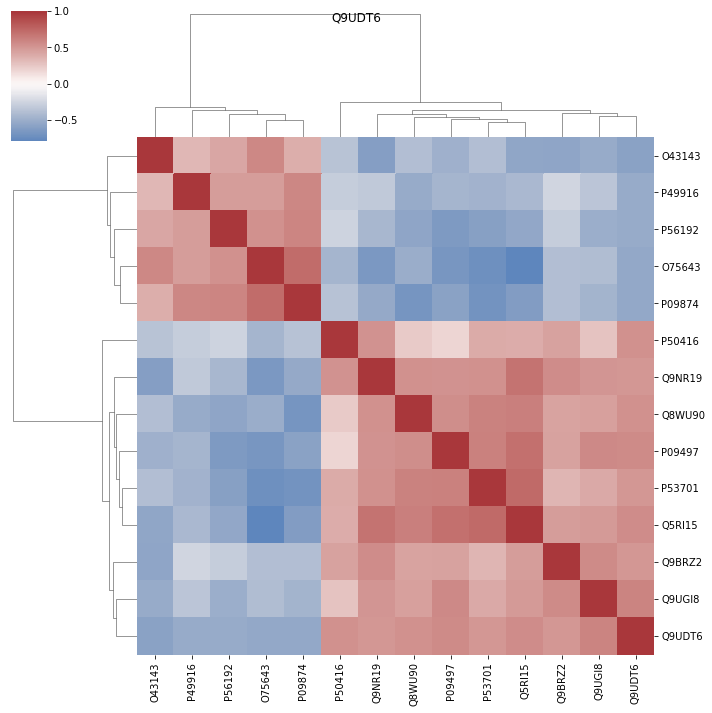

In [54]:
corred = get_correlation_matrix(dataset, ["Q9UDT6"], ["CRC"], .5)

In [55]:
for x in corred.values():
    for p in x:
        print(p)

O43143
O75643
P09497
P09874
P49916
P50416
P53701
P56192
Q5RI15
Q8WU90
Q9BRZ2
Q9NR19
Q9UGI8


3. RNA-binding protein 4 (Q9BWF3)

loss leads to imbalanced expression of Q9UKA9 leading to FGFR2 and PMK2 increase --> metabolic signature of CRC cells

In [26]:
all_data=all_data.reset_index()

In [36]:
meta[meta.Group=="CRC"][all_data.loc[meta.Group == "CRC","Q9UKA9"].notna()]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
206,1844,CFP_HT29_28m_1,592,HT29,adenocarcinoma,/,colon,/,NaN,PXD018066,187330,39521,13884,1912,FASP,Q-exactive,32343577,0,IONBOT_v0.6.3,CRC
207,1844,CFP_HT29_28m_2,592,HT29,adenocarcinoma,/,colon,/,NaN,PXD018066,183043,37038,12894,1868,FASP,Q-exactive,32343577,0,IONBOT_v0.6.3,CRC


In [38]:
# Erk in feature names
"P28482" in feature_names

True

Correlation between RNA-binding protein 4  and Mitogen-activated protein kinase 1 
Pearson correlation: -0.07 (p-val: 0.5671457905969489)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


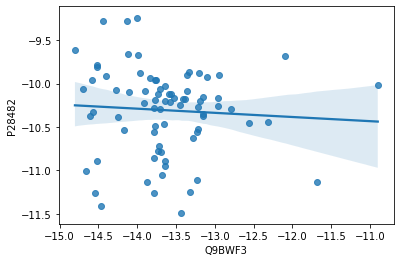

In [51]:
make_regplot(["CRC"], "Q9BWF3", "P28482")

Correlation between RNA-binding protein 4  and RAC-alpha serine/threonine-protein kinase 
Pearson correlation: -0.04 (p-val: 0.7299773628032745)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


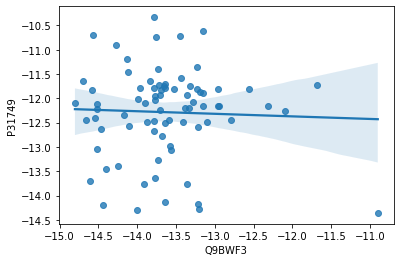

In [52]:
make_regplot(["CRC"], "Q9BWF3", "P31749")

P40227
P50991
P61981
Q5VW36
Q9HB71


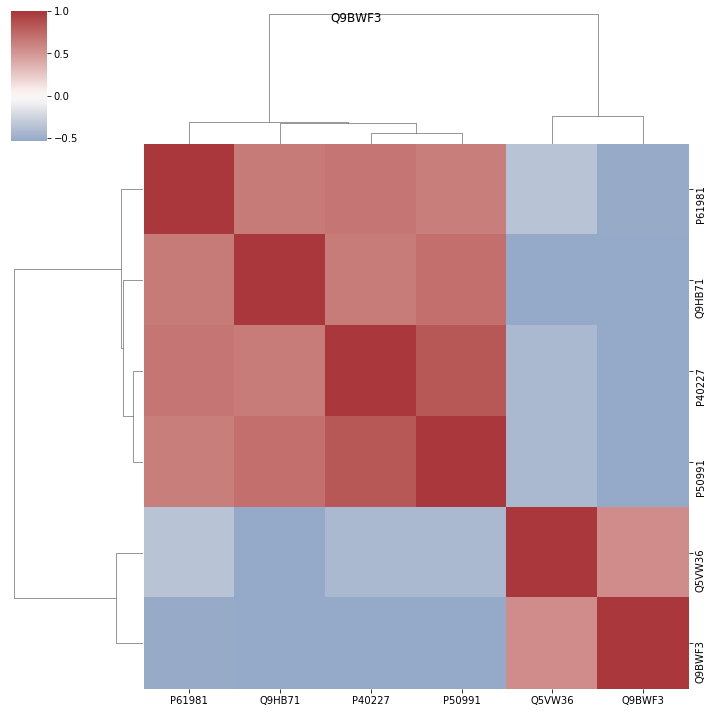

In [59]:
corred = get_correlation_matrix(dataset, ["Q9BWF3"], ["CRC"], .5)
for x in corred.values():
    for i in x:
        print(i)

In [60]:
uniprot_description.loc["""P40227
P50991
P61981
Q5VW36
Q9HB71""".split("\n")]

,description
uniprot_id,
P40227,T-complex protein 1 subunit zeta
P50991,T-complex protein 1 subunit delta
P61981,14-3-3 protein gamma
Q5VW36,Focadhesin
Q9HB71,Calcyclin-binding protein


4. scaffold attachment factor B2

O00148
O00743
O15213
O43422
O60264
O60870
O75533
O75643
O75947
O95674
O95721
P00505
P04080
P08621
P09874
P11387
P11388
P17900
P40926
P51148
P52294
P56385
P62269
P62306
P62805
P62906
P62995
Q08211
Q09161
Q13769
Q14676
Q15029
Q15061
Q15428
Q2TAY7
Q5W111
Q6P2Q9
Q6PL18
Q8IWA0
Q8NAV1
Q8NBJ4
Q8NE01
Q8TEA8
Q92621
Q96AT1
Q96KR1
Q9BQ61
Q9HB90
Q9HBH1
Q9HCD5
Q9NRX1
Q9NVH1
Q9P1F3
Q9UIG0
Q9UMY1
Q9Y2R4


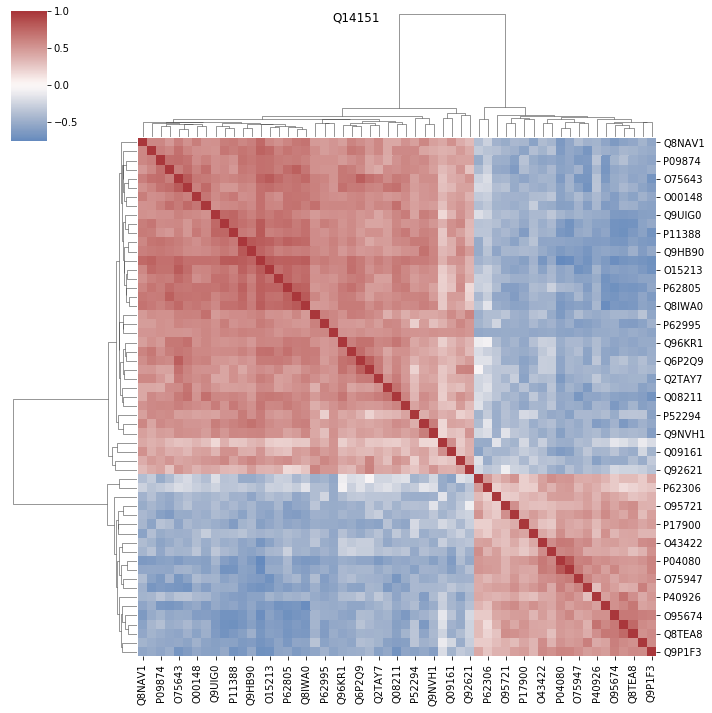

In [74]:
corred = get_correlation_matrix(dataset, ["Q14151"], ["CRC"], .5)
for x in corred.values():
    for i in x:
        print(i)

O60264
P51148
Q14676
Q8IWA0
Q8WYP5
Q9UIG0


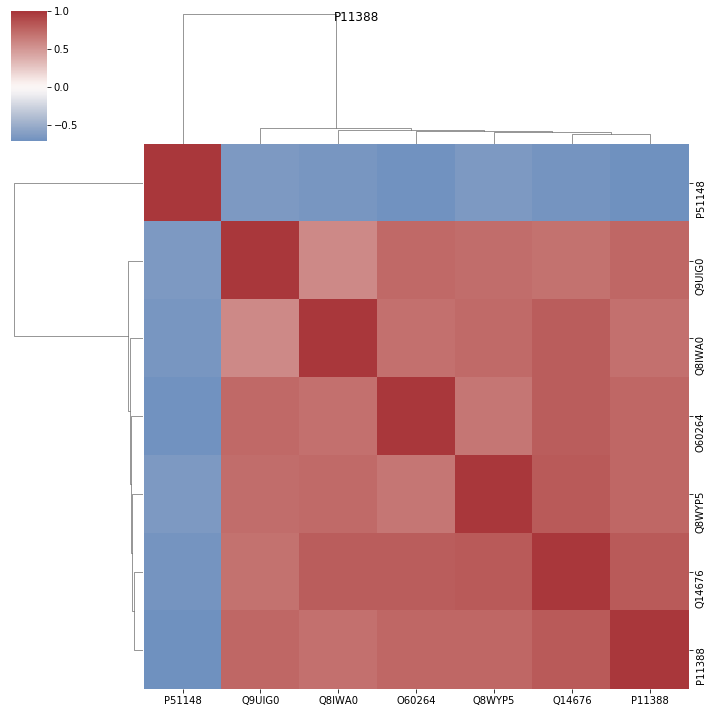

In [83]:
corred = get_correlation_matrix(dataset, ["P11388"], ["CRC"], .7)
for x in corred.values():
    for i in x:
        print(i)

Parathymosin and prothymosin alpha

---

# HEK293

In [46]:
# podocalyxin: O00592

mean_podocalyxin = {}
for i in meta.Group.unique():
    mean_podocalyxin[i] = dataset.loc[meta.Group == i, "O00592"].median()

<BarContainer object of 15 artists>

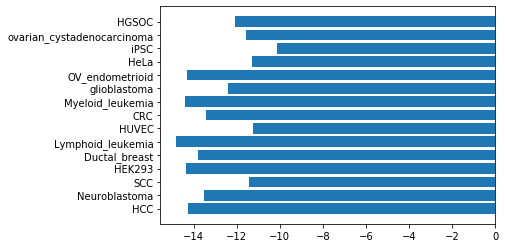

In [47]:

plt.barh(y=list(mean_podocalyxin.keys()), width=mean_podocalyxin.values() )

---

# iPSC

nanog sox2 oct4: Q9H9S0 P48431 Q01860. SOX2 and OCT4 are expressed in iPSC

In [45]:
all_data.reset_index(drop=True).loc[:, "P48431 Q01860".split()].notna().sum()

P48431    40
Q01860    19
dtype: int64

In [49]:
# Expression of nestin


median_nestin = {}
for i in meta.Group.unique():
    median_nestin[i] = list(dataset.loc[meta.Group == i, "P48681"])


In [60]:
meta[meta.Group == "Ductal_breast"].cell_line.unique()

array(['MCF7', 'ZR751', 'SKBR3', 'MDA-MB-231', 'MDA-MB-453', 'MDA-MB-468',
       'DU4475', 'HCC1143', 'MFM223', 'HCC1937', 'HCC1599', 'HS578T',
       'BT20', 'MDA-MB-157', 'BT549', 'HCC38', 'MDA-MB-436'], dtype=object)

In [67]:
dataset.max().max()

-5.565812695277335

In [73]:
dataset_db = dataset[meta.Group == "Ductal_breast"]

In [74]:
dataset_db["cell_line"] = meta[meta.Group == "Ductal_breast"].cell_line

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


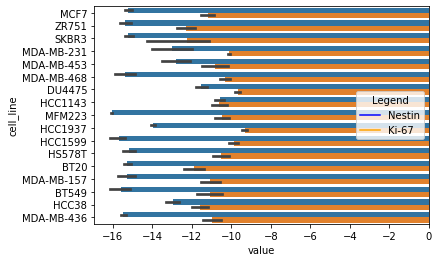

In [93]:
sns.barplot(data=dataset_db.loc[:,["P48681", "P46013", "cell_line"]].melt(id_vars="cell_line"),
            x="value", y="cell_line", hue="variable")

line1 = plt.Line2D([], [], color='blue', label='Nestin')
line2 = plt.Line2D([], [], color='orange', label='Ki-67')

# Set the legend handles and title
plt.legend(handles=[line1, line2], title="Legend")

In [102]:
len(DB_cells)

17

<BarContainer object of 17 artists>

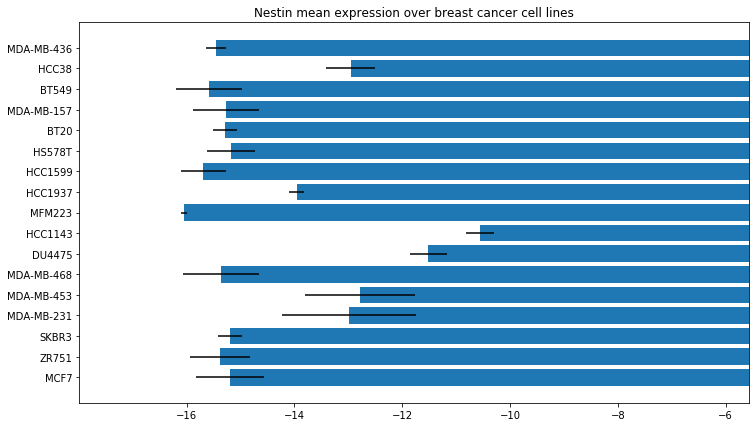

In [69]:
DB_cells = ['MCF7', 'ZR751', 'SKBR3', 'MDA-MB-231', 'MDA-MB-453', 'MDA-MB-468',
       'DU4475', 'HCC1143', 'MFM223', 'HCC1937', 'HCC1599', 'HS578T',
       'BT20', 'MDA-MB-157', 'BT549', 'HCC38', 'MDA-MB-436']

nestin_mean = []
nestin_std = []
for cell in DB_cells:
    nestin_mean.append(dataset.loc[meta.cell_line == cell, "P48681"].mean())
    nestin_std.append(dataset.loc[meta.cell_line == cell, "P48681"].std())

plt.figure(figsize=(12,7))
plt.xlim((dataset.min().min(), dataset.max().max()))
plt.title("Nestin mean expression over breast cancer cell lines")
plt.barh(y=DB_cells, width=nestin_mean, xerr=nestin_std)

<BarContainer object of 17 artists>

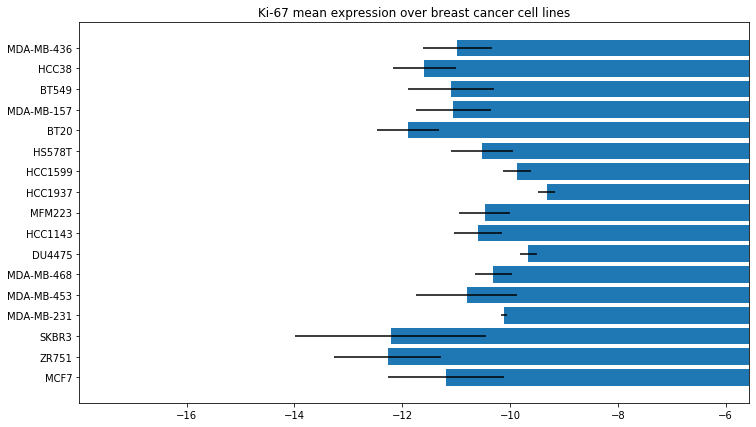

In [70]:
nestin_mean = []
nestin_std = []
for cell in DB_cells:
    nestin_mean.append(dataset.loc[meta.cell_line == cell, "P46013"].mean())
    nestin_std.append(dataset.loc[meta.cell_line == cell, "P46013"].std())

plt.figure(figsize=(12,7))
plt.xlim((dataset.min().min(), dataset.max().max()))
plt.title("Ki-67 mean expression over breast cancer cell lines")
plt.barh(y=DB_cells, width=nestin_mean, xerr=nestin_std)
 

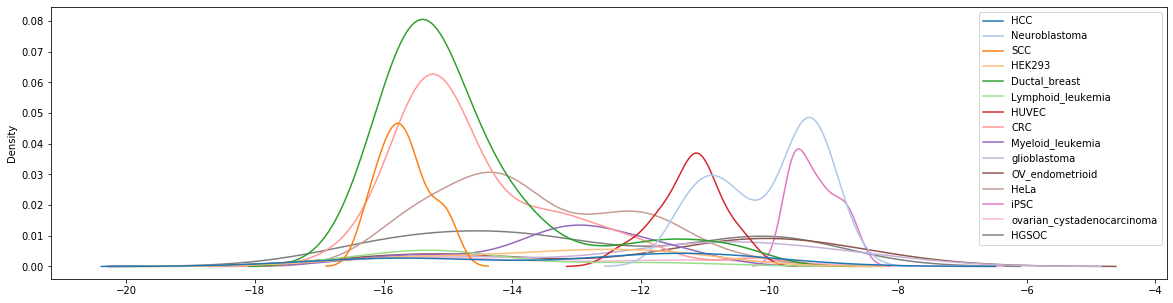

In [59]:
plt.figure(figsize=(20,5))
sns.kdeplot(data=median_nestin, common_norm=True, palette=sns.color_palette("tab20")[:15])

In [ ]:
meta.Groups.unique()

P05787
P08670
P46821
Q9Y446


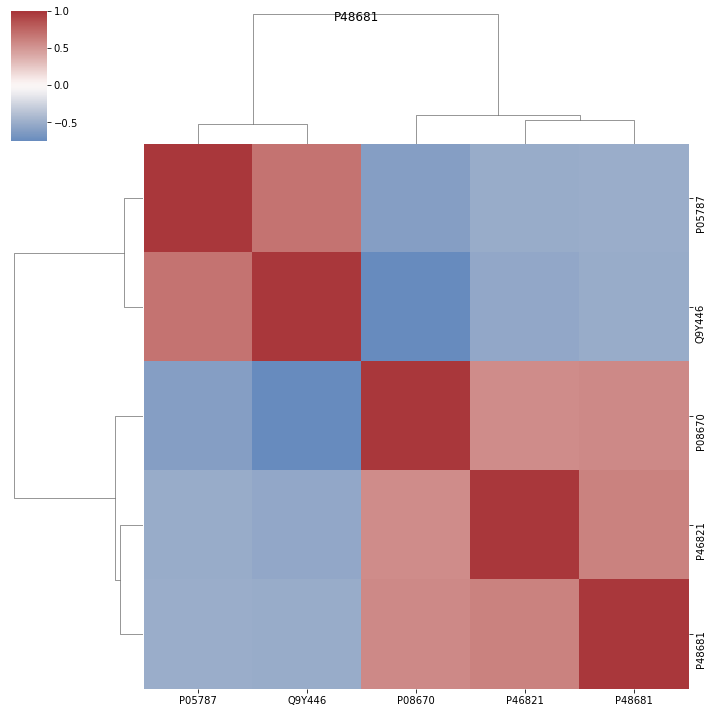

In [101]:
corred = get_correlation_matrix(dataset, ["P48681"], meta.Group.unique(), .5)
for c in corred.values():
    for p in c:
        print(p)

In [103]:
uniprot_description.loc["""P05787
P08670
P46821
Q9Y446""".split("\n")]

,description
uniprot_id,
P05787,"Keratin, type II cytoskeletal 8"
P08670,Vimentin
P46821,Microtubule-associated protein 1B
Q9Y446,Plakophilin-3


---

In [111]:
dataset.loc[meta.Group == cell, "A0MZ66"].mean()

-11.088561689800414

# Shootin-1 and Neural cell adhesion molecule L1 (L1CAM)
Shootin-1 absent in neuroblastoma and L1CAM most abundant

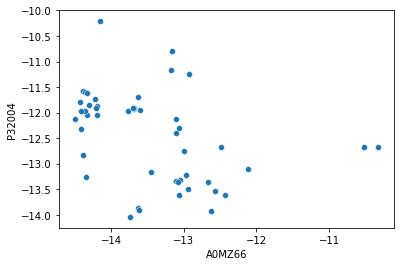

In [119]:
sns.scatterplot(data=dataset[meta.Group=="Neuroblastoma"], x="A0MZ66", y="P32004")

<BarContainer object of 15 artists>

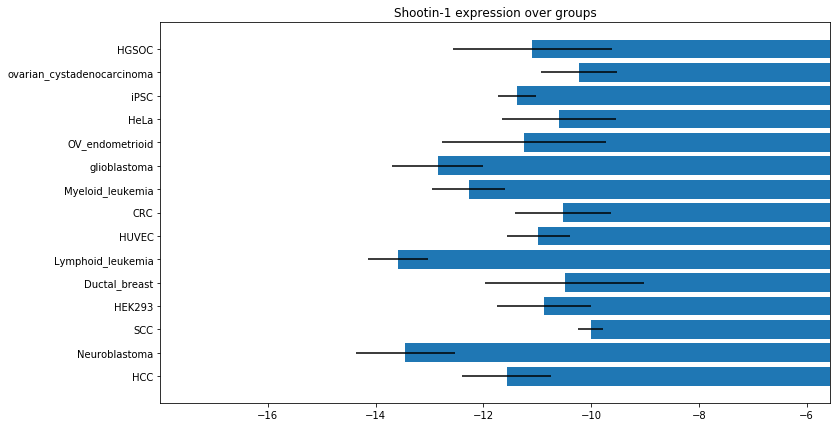

In [112]:
groups = meta.Group.unique()
nestin_mean = []
nestin_std = []
for cell in groups:
    nestin_mean.append(dataset.loc[meta.Group == cell, "A0MZ66"].mean())
    nestin_std.append(dataset.loc[meta.Group == cell, "A0MZ66"].std())

plt.figure(figsize=(12,7))
plt.xlim((dataset.min().min(), dataset.max().max()))
plt.title("Shootin-1 expression over groups")
plt.barh(y=groups, width=nestin_mean, xerr=nestin_std)
 

In [113]:
meta[meta.Group == "Neuroblastoma"].cell_line.unique()

array(['LAN5', 'SHSY5Y', 'SKNBE2'], dtype=object)

<BarContainer object of 3 artists>

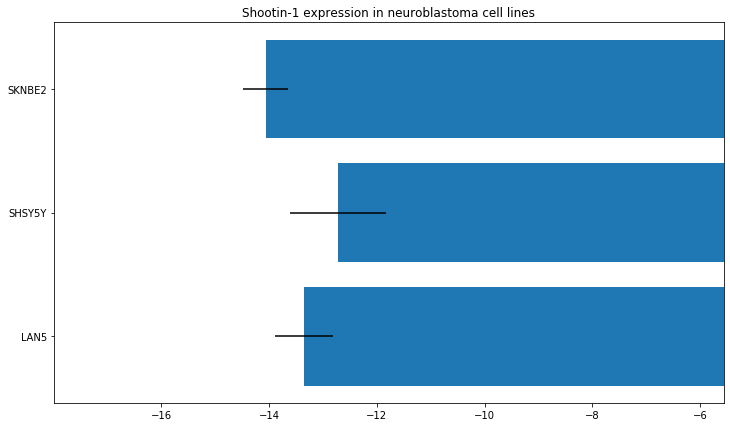

In [114]:
groups = ['LAN5', 'SHSY5Y', 'SKNBE2']
nestin_mean = []
nestin_std = []
for cell in groups:
    nestin_mean.append(dataset.loc[meta.cell_line == cell, "A0MZ66"].mean())
    nestin_std.append(dataset.loc[meta.cell_line == cell, "A0MZ66"].std())

plt.figure(figsize=(12,7))
plt.xlim((dataset.min().min(), dataset.max().max()))
plt.title("Shootin-1 expression in neuroblastoma cell lines")
plt.barh(y=groups, width=nestin_mean, xerr=nestin_std)

# HCC

In [ ]:
# ERK1 = P27361
# ERK2 = P28482 -> present in filtered PEMatrix

Correlation between Mitogen-activated protein kinase 1  and Dual specificity protein phosphatase 3 
Pearson correlation: -0.14 (p-val: 0.6482926858793808)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


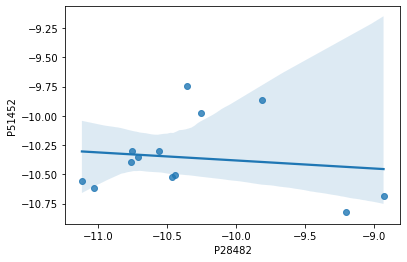

In [62]:
make_regplot(["HCC"], "P28482", "P51452")

Correlation between Testis-expressed protein 10 and Dual specificity protein phosphatase 3 
Pearson correlation: 0.91 (p-val: 2.0656021128281467e-05)


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


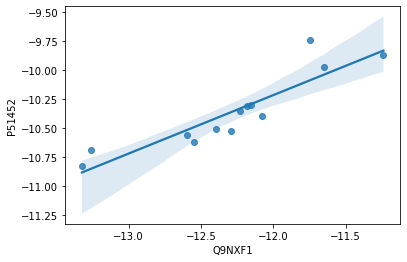

In [71]:
make_regplot(["HCC"], "Q9NXF1", "P51452")

P42695
Q6PML9
Q92688
Q9NXF1
Q9Y570


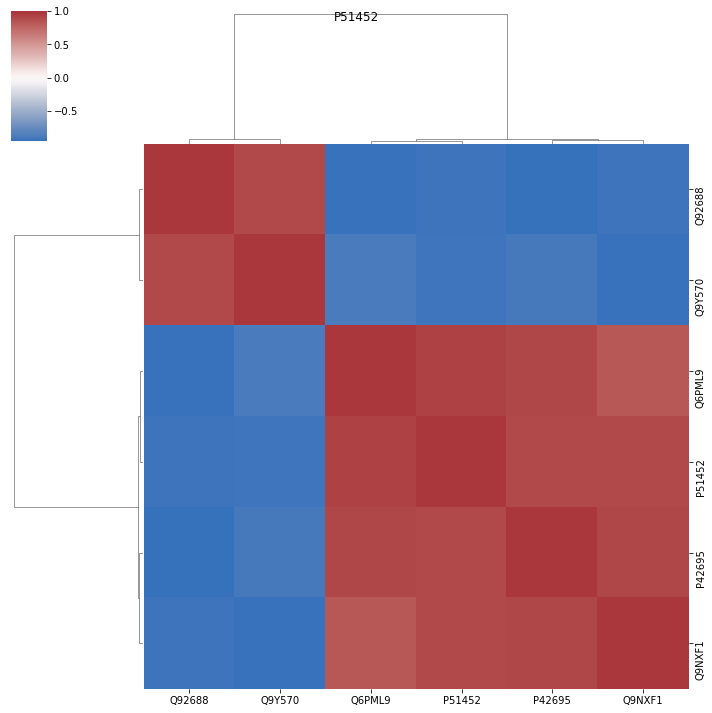

In [67]:
corred = get_correlation_matrix(dataset, ["P51452"], ["HCC"], .9)
for c in corred.values():
    for p in c:
        print(p)

In [73]:
uniprot_description.loc["""P42695
Q6PML9
Q92688
Q9NXF1
Q9Y570""".split("\n")]

,description
uniprot_id,
P42695,Condensin-2 complex subunit D3
Q6PML9,Zinc transporter 9
Q92688,Acidic leucine-rich nuclear phosphoprotein 32 ...
Q9NXF1,Testis-expressed protein 10
Q9Y570,Protein phosphatase methylesterase 1


In [ ]:
corred = get_correlation_matrix(dataset, ["P51452"], ["HCC"], .9)
for c in corred.values():
    for p in c:
        print(p)

In [74]:
meta[meta.Group == "HCC"].cell_line.unique()

array(['Hep3B', 'MHCC97', 'HepG2'], dtype=object)

---

In [26]:
meta[meta.Group == "HEK293"]

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
32,1820,161021_deSDS_Digested_cells_1SDS_01_A,556,HEK293,healthy,/,fetal kidney,HEK293F,NaN,PXD006035,40216,7051,1918,314,"in-solution, FASP",LTQ Orbitrap Velos,29888605,1,IONBOT_v0.6.2,HEK293
33,1820,161021_deSDS_Digested_cells_1SDS_01_B,556,HEK293,healthy,/,fetal kidney,HEK293F,NaN,PXD006035,33347,5174,1385,282,"in-solution, FASP",LTQ Orbitrap Velos,29888605,2,IONBOT_v0.6.2,HEK293
34,1820,170322_HEK_RP_01_A,556,HEK293,healthy,/,fetal kidney,HEK293F,NaN,PXD006035,22447,3818,1096,250,"in-solution, FASP",LTQ Orbitrap Velos,29888605,3,IONBOT_v0.6.2,HEK293
35,1820,170322_HEK_RP_01_B,556,HEK293,healthy,/,fetal kidney,HEK293F,NaN,PXD006035,25398,3888,1119,230,"in-solution, FASP",LTQ Orbitrap Velos,29888605,4,IONBOT_v0.6.2,HEK293
197,1841,EOT12-1010,590,HEK293,adenocarcinoma,/,breast,HEK293-L10a,NaN,PXD008693,24689,1150,390,231,in-solution,LTQ Orbitrap Elite,30125121,1,IONBOT_v0.6.2,HEK293
228,1848,b1906_293T_proteinID_01A_QE3_122212,596,HEK293,healthy,/,kidney,/,NaN,PXD001468,157928,25672,8386,2176,in-solution,Q-exactive,26076430,1,IONBOT_v0.7.0,HEK293
239,1861,fr_opt_n02_r02,596,HEK293,healthy,/,kidney,/,NaN,PXD002613,1255,460,182,112,in-solution,Q-exactive,27233776,2,IONBOT_v0.7.0,HEK293
240,1861,fr_opt_n02_r03,596,HEK293,healthy,/,kidney,/,NaN,PXD002613,2553,457,178,106,in-solution,Q-exactive,27233776,3,IONBOT_v0.7.0,HEK293
241,1861,fr_opt_n03_r01,596,HEK293,healthy,/,kidney,/,NaN,PXD002613,8449,1186,427,266,in-solution,Q-exactive,27233776,1,IONBOT_v0.7.0,HEK293
242,1861,MSA_09_new_column_04H_r01,596,HEK293,healthy,/,kidney,/,NaN,PXD002613,197014,32464,10259,2160,in-solution,Q-exactive,27233776,0,IONBOT_v0.7.0,HEK293


# Glioblastoma and integrin alpha 3

In [17]:
itga3 = matched_string_correlations[(matched_string_correlations.protein1 == "P26006") | (matched_string_correlations.protein2 == "P26006")]

In [22]:
itga3[itga3.value > .4]

,protein1,protein2,value,combined_score
167698,P04083,P26006,0.441109,225.0
167722,P06703,P26006,0.499293,253.0
167821,P16144,P26006,0.451624,967.0
167842,P17655,P26006,0.426501,220.0
167881,P21980,P26006,0.479632,490.0
181480,P26006,P29317,0.412705,829.0
717582,P26006,Q14764,0.502311,0.0
889690,P26006,Q5GLZ8,0.404498,0.0
993924,P26006,Q6NZI2,0.543774,174.0
1219720,P26006,Q8IWE2,0.424386,0.0


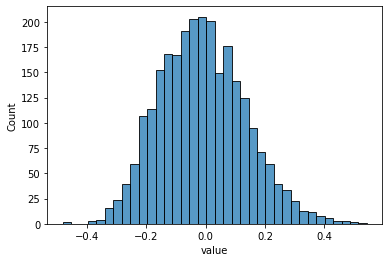

In [19]:
sns.histplot(itga3.value)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


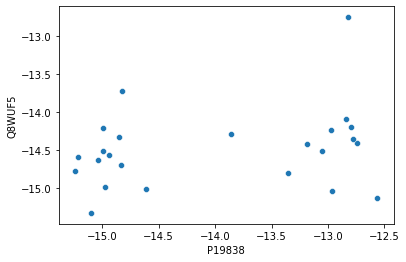

In [105]:
sns.scatterplot(dataset.loc[meta.Group == "glioblastoma", "P19838"], dataset.loc[meta.Group == "glioblastoma", "Q8WUF5"])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


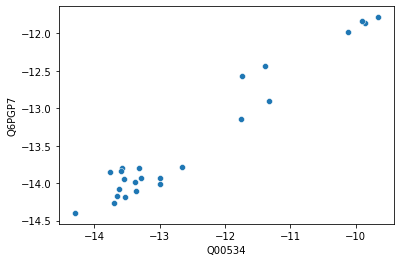

In [25]:
sns.scatterplot(dataset.loc[meta.Group == "glioblastoma", "Q00534"], dataset.loc[meta.Group == "glioblastoma", "Q6PGP7"])

O00151
O43592
O60244
O75165
P07199
P09382
P17655
P21980
P37837
P46100
Q00534
Q12965
Q13049
Q13315
Q5GLZ8
Q69YN4
Q6PGP7
Q7Z434
Q8IY18
Q8NAV1
Q92990
Q93034
Q96FQ6
Q96G46
Q9BYT8
Q9BZQ8
Q9C0E2
Q9UHD1
Q9Y232


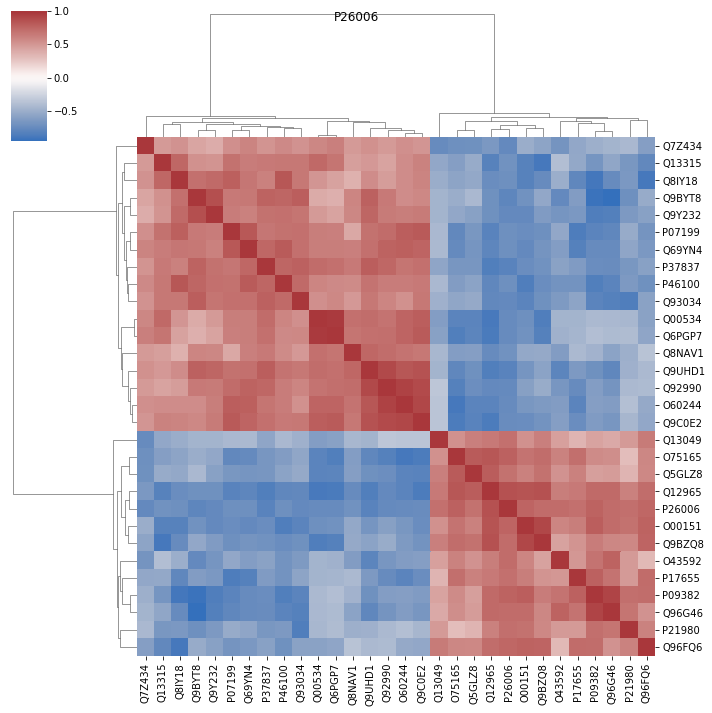

In [24]:
corred = get_correlation_matrix(dataset, ["P26006"], ["glioblastoma"], .7)
for x in corred.values():
    for i in x:
        print(i)

---

# Rela associated inhibitor and SCC

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


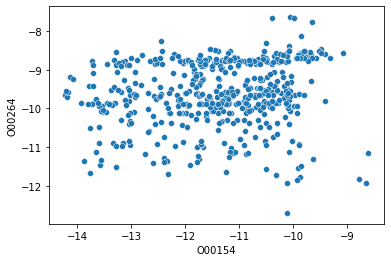

In [119]:
sns.scatterplot(dataset.loc[:, "O00154"],dataset.loc[:, "O00264"]
)

O14672
O60832
O75157
O76094
P07384
P14866
P14923
P16144
P17252
P20073
P21281
P28070
P31930
P46976
P50995
Q00839
Q01970
Q08257
Q13123
Q14116
Q14166
Q15208
Q16513
Q8IZ21
Q8NI22
Q92900
Q9BVJ7
Q9H223
Q9H773
Q9P206
Q9UHY7
Q9UK59
Q9Y446


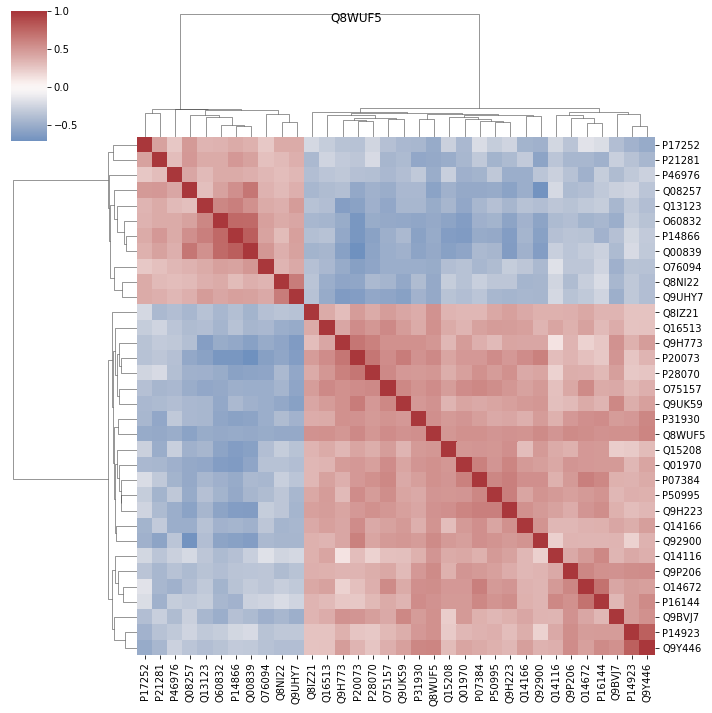

In [124]:
corred = get_correlation_matrix(dataset, ["Q8WUF5"], ["SCC","Ductal_breast","glioblastoma", "HCC", "CRC"], .5)
for x in corred.values():
    for i in x:
        print(i)

HCC important proteins in correlation context

In [108]:
HCC_important = ['O60701',
 'P05091',
 'P21266',
 'P29218',
 'P51452',
 'Q01970',
 'Q08J23',
 'Q9HC35']

Q01970 no correlations above 0.9 found


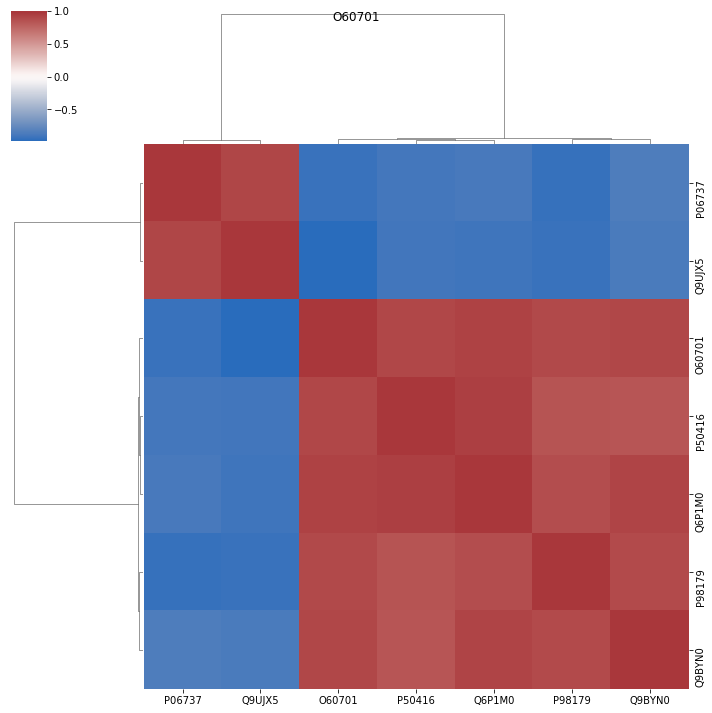

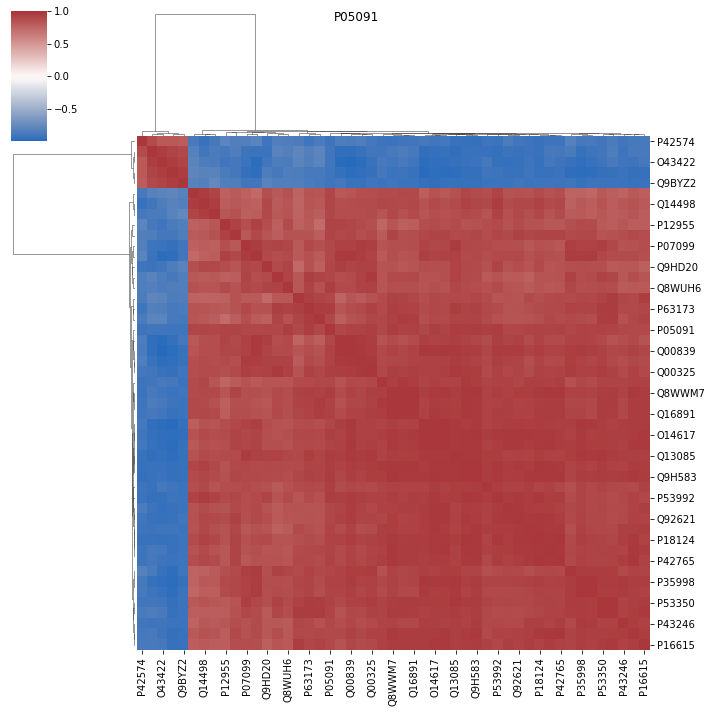

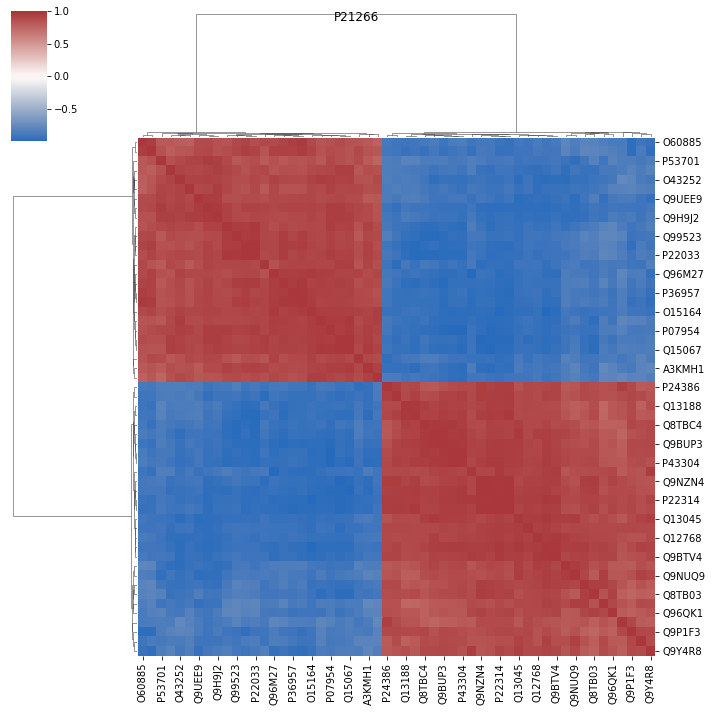

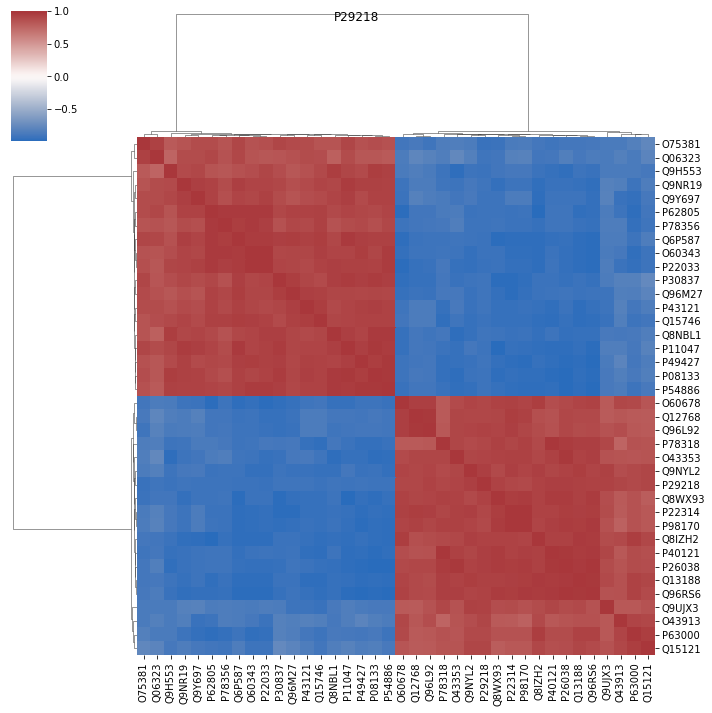

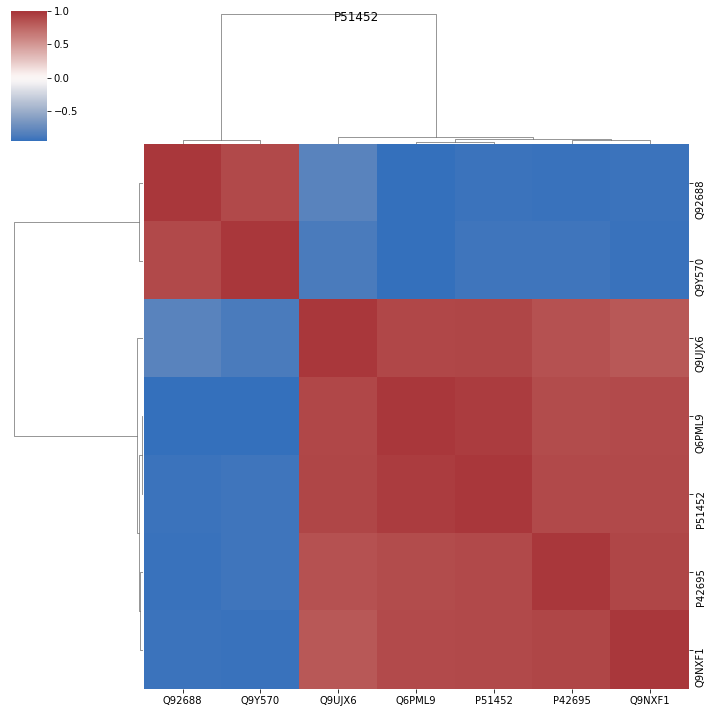

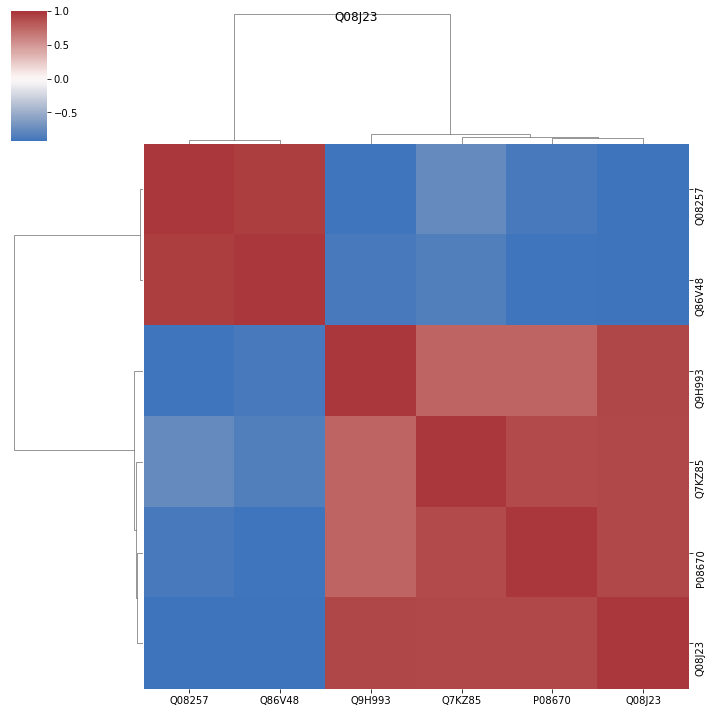

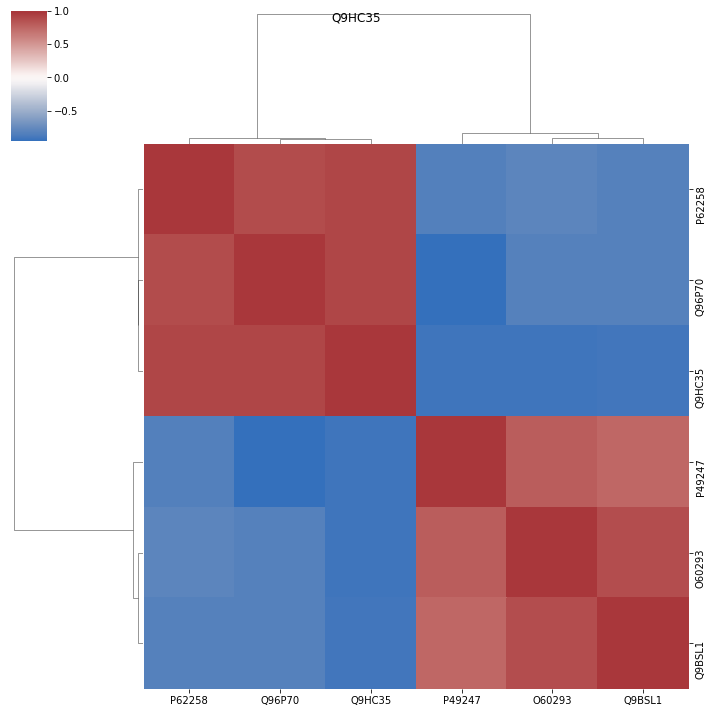

In [164]:
correlation_dictionaries = []
for prot in HCC_important:
    correlation_dictionaries.append(get_correlation_matrix(dataset, [prot], ["HCC"], .9))

In [165]:
correlation_dictionaries

[{'O60701': Index(['P06737', 'P50416', 'P98179', 'Q6P1M0', 'Q9BYN0', 'Q9UJX5'], dtype='object')},
 {'P05091': Index(['O00567', 'O00625', 'O14617', 'O15042', 'O15446', 'O43422', 'O43818',
         'P07099', 'P12955', 'P16435', 'P16615', 'P18124', 'P20020', 'P22695',
         'P35998', 'P39019', 'P41252', 'P42574', 'P42765', 'P43246', 'P49327',
         'P49589', 'P50914', 'P53350', 'P53992', 'P57740', 'P62241', 'P63173',
         'Q00325', 'Q00839', 'Q13085', 'Q14498', 'Q15125', 'Q16891', 'Q86UE4',
         'Q86X55', 'Q8WUH6', 'Q8WWM7', 'Q92621', 'Q9BYZ2', 'Q9H0A0', 'Q9H2U1',
         'Q9H583', 'Q9HD20', 'Q9NR09', 'Q9UKZ1', 'Q9Y2Z4', 'Q9Y5Q9'],
        dtype='object')},
 {'P21266': Index(['A3KMH1', 'O15047', 'O15164', 'O43252', 'O60343', 'O60678', 'O60885',
         'O75165', 'O75915', 'O94826', 'O95340', 'P07954', 'P17900', 'P22033',
         'P22314', 'P24386', 'P30837', 'P36957', 'P43304', 'P45954', 'P48163',
         'P53701', 'P61221', 'P98170', 'Q12768', 'Q13045', 'Q13188', 'Q1469

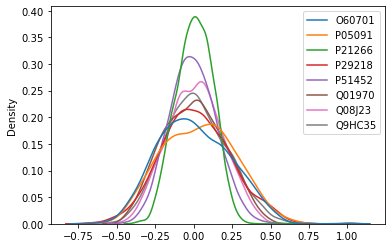

In [117]:
sns.kdeplot(data=HCC_corr)

In [130]:
corred = HCC_corr[((HCC_corr > .5) | (HCC_corr<-.5)).any(axis=1)].index

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


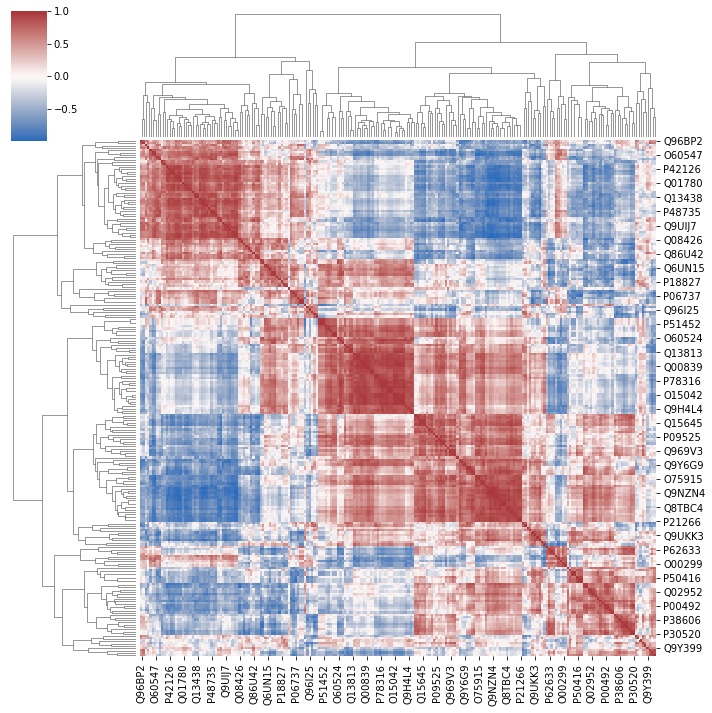

In [131]:
sns.clustermap(HCC_data.loc[:, list(corred)+HCC_important].corr(), cmap="vlag", center=0)

In [118]:
corred = HCC_corr[(HCC_corr > .5) | (HCC_corr<-.5)].index

---